In [77]:
# !pip install tqdm
# !pip install numpy
# !pip install scipy
# !pip install matplotlib
# !pip install autograd
# !pip install pandas

In [78]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utility function
def summarize_array(arr):
    return {
        "mean": np.mean(arr),
        "std": np.std(arr),
        "min": np.min(arr),
        "25%": np.percentile(arr, 25),
        "50% (median)": np.median(arr),
        "75%": np.percentile(arr, 75),
        "max": np.max(arr)
    }

n_features = 112
n_samples = 8124

In [79]:
# Load the data
X = np.zeros((n_samples, n_features))
y = np.zeros(n_samples, dtype=np.int64)
with open('mushrooms.txt', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        y[i] = int(line[0])
        features = line[2:].split()
        features = [int(feature.split(':')[0]) for feature in features]
        features = [feature - 1 for feature in features]     # Features are 1-indexed in the dataset 
        X[i, features] = 1

y = y - 1       # Changing labels from 1 and 2 to 0 and 1

In [80]:
np.bincount(y)

array([3916, 4208])

/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/matthieuneau/.pyenv/versions/3.12.8/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


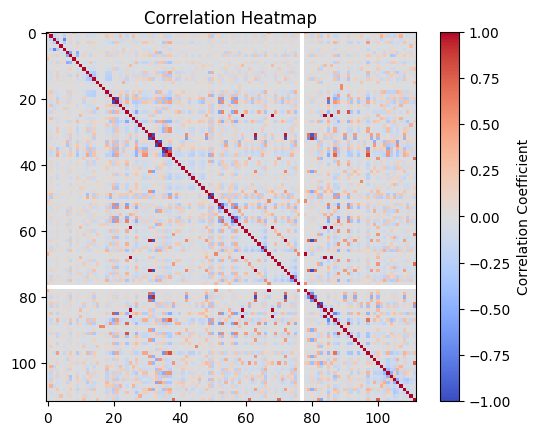

In [81]:
correlation_matrix =np.corrcoef(X.T)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Heatmap')
plt.show()

0.023007450962255982


Text(0.5, 1.0, 'marginal absolute correlation with target')

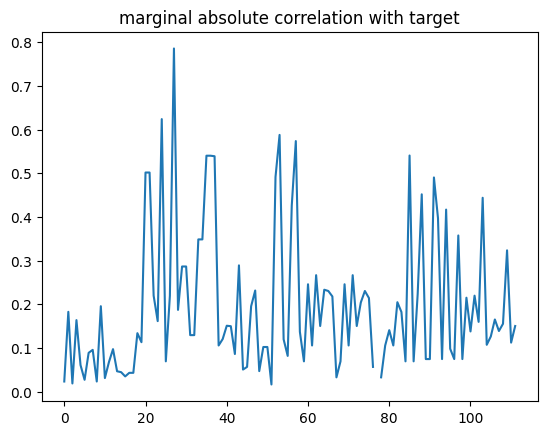

In [82]:
marginal_correlations = [np.abs(np.corrcoef(X[:,i], y)[0,1]) for i in range(n_features)]
print(marginal_correlations[0])

plt.plot(range(n_features), marginal_correlations)
plt.title('marginal absolute correlation with target')

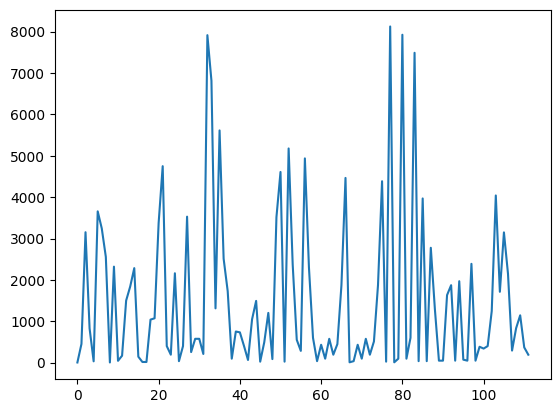

In [83]:
features_presence = [np.count_nonzero(X[:,i]) for i in range(n_features)]
plt.plot(range(n_features), features_presence)

### Number of features per entry
This shows that each row has exactly 21 features


In [84]:
features_per_row = X.sum(axis=1, dtype=np.int64)
print(np.bincount(features_per_row))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 8124]


### Row correlation

The rows are somewhat correlated, forming 5 or 6 distinct groups

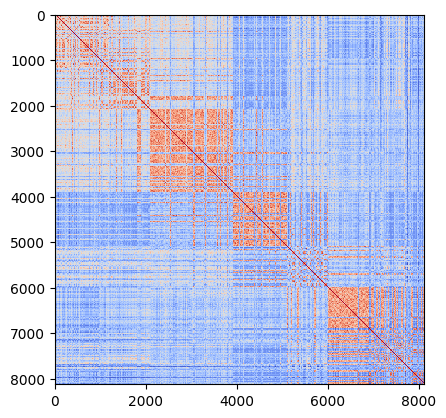

In [85]:
plt.imshow(np.corrcoef(X), cmap='coolwarm', interpolation='nearest')

### Q2

In [86]:
from autograd import grad
def loss(x: np.ndarray): 
    """x are the parameters. Confusing but consistent with the notations in the problem"""
    z = 1 + np.exp(-X @ x)
    z = 1/z
    return (1/n_samples) * np.sum((y - z)**2)

def manual_grad(x: np.ndarray):
    return (X.T @ ((-2 * np.exp(X@x)) * (1/(1+ np.exp(X@x))**3) * (np.exp(X@x)*(y - 1) + y)))/n_samples

grad_loss = grad(loss)

# Checking that our implementation of the gradient is correct
test_x = np.random.rand(n_features)
assert np.allclose(grad_loss(test_x), manual_grad(test_x))

### Q3

In [87]:
def grad_desc(x0: np.ndarray, alpha: float, n_iter: int):
    x = x0.copy()
    loss_history = []
    for i in range(n_iter):
        x = x - alpha * grad_loss(x)
        loss_history.append(loss(x))
    return x, loss_history

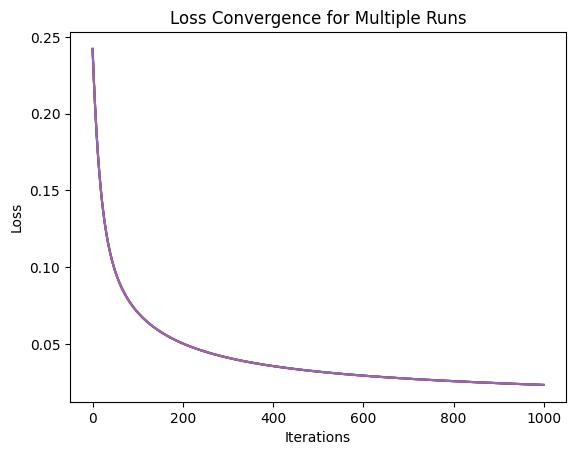

In [88]:
for _ in range(5):
    x0 = np.zeros(n_features)
    alpha = 0.1
    n_iter = 1000
    _, loss_history = grad_desc(x0, alpha, n_iter)  
    plt.plot(range(n_iter), loss_history)  

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Convergence for Multiple Runs")
plt.show()

### Q4

In [89]:
def stochastic_grad(x: np.ndarray, batch_size: int = 1):
    indices = np.random.choice(n_samples, batch_size, replace=False)
    grad = np.zeros(n_features)
    for index in indices:
        grad += -2 * np.exp(np.dot(X[index], x)) * (np.exp(np.dot(X[index], x)) * (y[index] - 1) + y[index]) * X[index] / (1 + np.exp(np.dot(X[index], x)))**3
    return grad / batch_size

def stochastic_grad_desc(x0: np.ndarray, alpha: float, n_iter: int, batch_size: int = 1):
    x = x0.copy()
    loss_history = []
    for i in range(n_iter):
        x -= alpha * stochastic_grad(x, batch_size)
        loss_history.append(loss(x))
    return x, loss_history

# Check that it is equivalent to grad desc when batch size is equal to the number of samples
assert np.allclose(stochastic_grad(test_x, batch_size=n_samples), manual_grad(test_x))

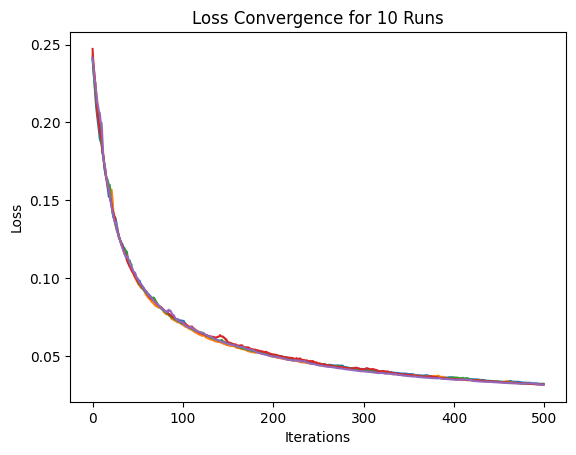

In [90]:
for _ in range(5):
    x0 = np.zeros(n_features)
    alpha = 0.1
    n_iter = 500
    batch_size = 10
    loss_history = stochastic_grad_desc (x0, alpha, n_iter, batch_size)[1]  
    plt.plot(range(n_iter), loss_history) 

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Convergence for 10 Runs")
plt.show()

### Q5

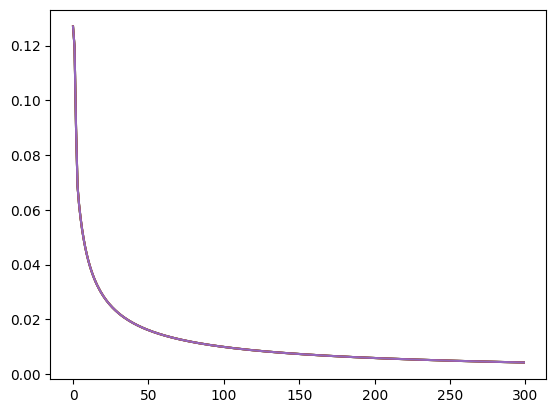

In [91]:
def adagrad(x0: np.ndarray, eta: float, n_iter: int, epsilon: float = 1e-8):
    x = x0.copy()
    G = np.zeros(n_features)
    loss_history = []
    for i in range(n_iter): 
        G += grad_loss(x)**2
        x = x - (eta/np.sqrt(G + epsilon)) * grad_loss(x)
        loss_history.append(loss(x))
    return x, loss_history

for _ in range(5):
    x0 = np.zeros(n_features)
    eta = 0.1
    n_iter = 300
    loss_history = adagrad(x0, eta, n_iter)[1]
    plt.plot(range(n_iter), loss_history)

Taking the same (initial) stepsize as stochastic gradient descent for eta shows a faster convergence of adagrad and a better final result than SGD with its best settings

### Q6

[22, 0.19642857142857142]
[16, 0.14285714285714285]
[23, 0.20535714285714285]
[13, 0.11607142857142858]
[18, 0.16071428571428573]


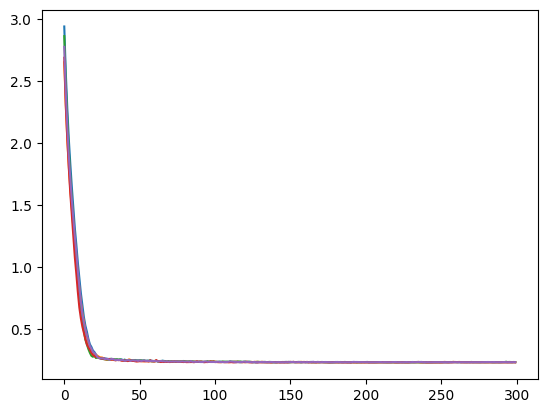

In [127]:
def regularized_loss(x: np.ndarray, lambda_: float):
    return loss(x) + np.linalg.norm(x, ord=1) * lambda_

def regularized_grad(x: np.ndarray, lambda_: float):
    return grad_loss(x) + lambda_ * np.sign(x)

def regularized_stochastic_grad(x: np.ndarray, lambda_: float, batch_size: int = 1):
    return stochastic_grad(x, batch_size) + lambda_ * np.sign(x)

def regularized_adagrad(x0: np.ndarray, eta: float, n_iter:int, lambda_: float, epsilon: float = 1e-8, batch_size: int = 1):
    x = x0.copy()
    G = np.zeros(n_features)
    loss_history = []
    for i in range(n_iter):
        g = regularized_stochastic_grad(x, lambda_, batch_size)
        G += g**2
        x_intermediate = x - (eta/np.sqrt(G + epsilon)) * g
        x = np.sign(x_intermediate)*np.maximum(np.abs(x_intermediate) - eta*lambda_, 0)
        loss_history.append(regularized_loss(x, lambda_))
    return x, loss_history

for _ in range(5):
    x0 = np.random.rand(n_features)
    eta = 0.1
    n_iter = 300
    lambda_ = 0.05
    batch_size = 100
    epsilon = 1e-8
    xs, loss_history = regularized_adagrad(x0, eta, n_iter, lambda_, epsilon, batch_size)
    print([np.count_nonzero(xs), np.count_nonzero(xs)/n_features])
    plt.plot(range(n_iter), loss_history)

### Q7

In [93]:
def bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, n_iter: int):
    x = x0.copy()
    H = H0.copy()
    g = grad_loss(x)
    loss_history = []

    for _ in tqdm(range(n_iter)):
        p = - H @ g
        t = t0
        x_new = x + t * p
        g_new = grad_loss(x_new)

        while (loss(x + t*p) > loss(x) + c_armijo * t * np.dot(g, p)):
            t *= 0.5
            x_new = x + t * p
            g_new = grad_loss(x_new)
        while (- np.dot(p, g_new)) < (- c_curvature * np.dot(p, g)):
            t *= 0.5
            x_new = x + t * p
            g_new = grad_loss(x_new)

        s = x_new - x
        y = g_new - g
        if np.dot(s, y) > 0:
            H = (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)).T @ H @ (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)) + np.outer(s, s)/np.dot(s, y)
        # H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        loss_history.append(loss(x))

    return x, loss_history

100%|██████████| 100/100 [00:00<00:00, 127.52it/s]


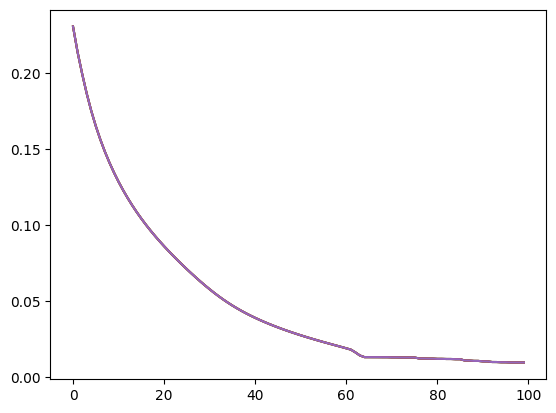

In [130]:
for _ in range(5):
    x0 = np.zeros(n_features)
    H0 = np.eye(n_features)
    t0 = 1
    c_armijo = 0.01
    c_curvature = 0.9
    n_iter = 100
    loss_history = bfgs(x0, H0, t0, c_armijo, c_curvature, n_iter)[1]
    plt.plot(range(n_iter), loss_history)

The method converges after about 60 epochs, which is 10 times faster than gradient descent. However, each iteration in much more costly so that we don't really benefit overall in that case

### Q8

In [137]:
def stochastic_bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, n_iter: int, batch_size=1):
    x = x0
    H = H0
    g = stochastic_grad(x, batch_size)
    loss_history = []

    for _ in tqdm(range(n_iter)):
        p = - H @ g
        t = t0
        x_new = x + t * p
        g_new = stochastic_grad(x_new, batch_size)
        count = 0

        while (loss(x + t*p) > loss(x) + c_armijo * t * np.dot(g, p)):
            t *= 0.5
            x_new = x + t * p
            g_new = stochastic_grad(x_new, batch_size)
        while (- np.dot(p, g_new)) < (- c_curvature * np.dot(p, g)):
            t *= 0.5
            x_new = x + t * p
            g_new = stochastic_grad(x_new, batch_size)

        s = x_new - x
        y = g_new - g
        H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        loss_history.append(loss(x))

    return x, loss_history

 62%|██████▏   | 62/100 [00:01<00:00, 47.09it/s]/var/folders/_y/2rw4wkns73v1mc9wlr3l0k_h0000gn/T/ipykernel_81885/2869227938.py:25: RuntimeWarning: invalid value encountered in divide
  H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


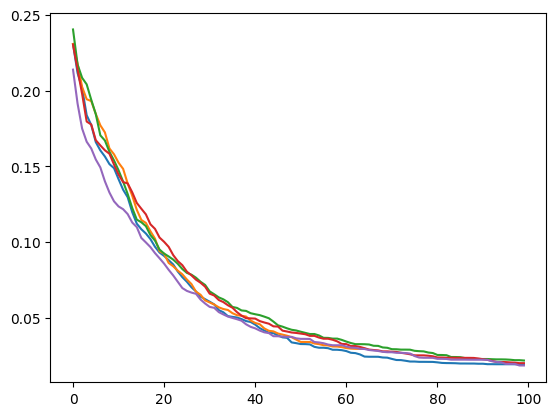

In [138]:
for _ in range(5):
    x0 = np.zeros(n_features)
    H0 = np.eye(n_features)
    t0 = 1
    n_iter = 100
    batch_size = 500
    c_armijo = .01
    c_curvature = .9
    loss_history = stochastic_bfgs(x0, H0, t0, c_armijo, c_curvature, n_iter, batch_size)[1]
    plt.plot(range(n_iter), loss_history)

The method converges after about 100 epochs, which is 5 times faster than SGD. However, each iteration in much more costly so that we don't really benefit overall in that case

### Q9

### Adagrad
Adagrad only needs to access $B$ data points at each iteration as it calls $stochastic\_grad$ once per iteration and $n\_samples$ when computing the loss. This totals to $O(n\_samples + n\_iter \cdot B)$ data points accessed.

At each iteration, $x$ and $G$ are updated, amounting to a total of $O(n\_iter)$ updates of $d$-dimensional vectors.

### Stochastic BFGS
Let $k$ be an upper bound on the number of iterations in the while loop. Each iteration makes $O(k)$ calls to the $stochastic\_grad$ function, which itself accesses $B$ data points where $B$ is the batch size. At the end of each iteration, the loss is computed, which requires accessing all the data points, i.e., $n\_samples$. In total, Stochastic BFGS therefore accesses $O(B \cdot n\_iter \cdot k) + O(n\_samples)$ data points.

The update of $H$ at each iteration represents $d$ updates of $d$-dimensional vectors (since $H$ is of dimension $d \times d$), and the while loop makes $k$ updates. The other updates are $O(1)$. Overall, this amounts to $O(n\_iter \cdot d \cdot k)$.


### Q10

In [176]:
def regularized_bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, lambda_:float, n_iter: int):
    x = x0.copy()
    H = H0.copy()
    g = regularized_grad(x, lambda_)
    regularized_loss_history = []

    for _ in tqdm(range(n_iter)):
        p = - H @ g
        t = t0
        x_new = x + t * p
        g_new = regularized_grad(x_new, lambda_)
        count = 0

        while (loss(x + t*p) > loss(x) + c_armijo * t * np.dot(g, p)):
            t *= 0.5
            x_new = x + t * p
            g_new = regularized_grad(x_new, lambda_)
        while (- np.dot(p, g_new)) < (- c_curvature * np.dot(p, g)):
            t *= 0.5
            x_new = x + t * p
            g_new = regularized_grad(x_new, lambda_)

        s = x_new - x
        y = g_new - g
        # if np.dot(s, y) > 0:
        #     H = (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)).T @ H @ (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)) + np.outer(s, s)/np.dot(s, y)
        H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        regularized_loss_history.append(regularized_loss(x, lambda_))

    return x, regularized_loss_history

100%|██████████| 20/20 [00:00<00:00, 263.85it/s]

[112, np.float64(0.0)]


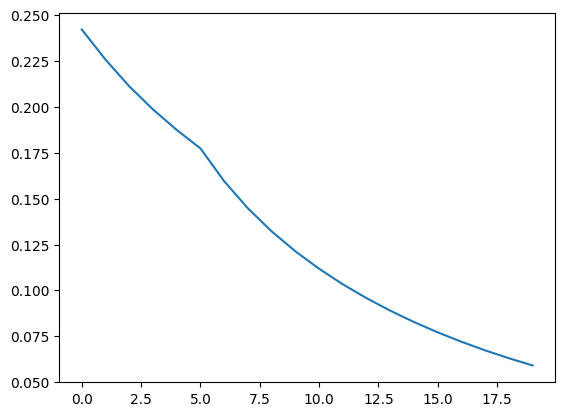

In [179]:
for _ in range(1):
    x0 = np.zeros(n_features)
    H0 = np.eye(n_features)
    t0 = .1
    c_armijo = 0.01
    c_curvature = 0.9
    lambda_ = 0
    n_iter = 20
    x_res, loss_history = regularized_bfgs(x0, H0, t0, c_armijo, c_curvature, lambda_, n_iter)
    print([np.count_nonzero(x_res), lambda_ * np.linalg.norm(x_res, ord=1)])
    plt.plot(range(n_iter), loss_history) 

### Q11

In [204]:
from collections import deque

def l_bfgs(x0: np.ndarray, H0: np.ndarray, t0: float, c_armijo: float, c_curvature: float, history_length: int, n_iter: int):
    x = x0
    H = H0
    s_history = deque(maxlen=history_length)
    y_history = deque(maxlen=history_length)
    loss_history = []

    # Perform a gradient step to initialize the algo
    g = grad_loss(x)
    xnew = x - .1 * g       # Same step size as in the GD implementation
    s_history.append(xnew - x)
    y_history.append(grad_loss(xnew) - g)
    x = xnew

    for i in tqdm(range(n_iter)):
        g = grad_loss(x)
        q = g.copy()
        for l in range(len(y_history)):
            if np.dot(s_history[-l], y_history[-l]) > 0:
                gamma = np.dot(s_history[-l], g) / np.dot(s_history[-l], y_history[-l])
                q -= gamma * y_history[-l] 

        for l in range(len(s_history)):
            if np.dot(s_history[-l], y_history[-l]) > 0:
                delta = np.dot(s_history[-l], g) / np.dot(s_history[-l], y_history[-l])
                q += (gamma - delta) * y_history[-l]  ## Gamma_l ??? 
                
        t = t0
        x_new = x + t * q
        g_new = grad_loss(x_new)
        q *= -1     # Direction of search is opposite to the gradient

        while (loss(x + t*q) > loss(x) + c_armijo * t * np.dot(g, q)):
            t *= 0.5
            x_new = x + t * q
            g_new = grad_loss(x_new)
        while np.abs(- np.dot(q, g_new)) > np.abs(- c_curvature * np.dot(q, g)):
            t *= 0.5
            x_new = x + t * q
            g_new = grad_loss(x_new)

        s = x_new - x
        y = g_new - g
        y_history.append(y)
        s_history.append(s)
        if np.dot(s, y) > 0:
            H = (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)).T @ H @ (np.eye(n_features) - np.outer(s, y)/np.dot(s,y)) + np.outer(s, s)/np.dot(s, y)
        # H = H + np.outer(s, s)/np.dot(s, y) - (H @ (np.outer(y, y)) @ H)/np.dot(y, H @ y)
        x, g = x_new, g_new
        loss_history.append(loss(x))

    return x, loss_history

In [ ]:
for _ in range(5):
    x0 = np.zeros(n_features)
    H0 = np.eye(n_features)
    t0 = 1
    c_armijo = 0.01
    c_curvature = 0.9
    history_length = 10
    n_iter = 20
    x_lbfgs, loss_history = l_bfgs(x0, H0, t0, c_armijo, c_curvature, history_length, n_iter)
    plt.plot(range(n_iter), loss_history)

  5%|▌         | 1/20 [00:23<07:35, 23.96s/it]